# Agentic RAG

[Retrieval Agents](https://python.langchain.com/v0.2/docs/tutorials/qa_chat_history/#agents) are useful when we want to make decisions about whether to retrieve from an index.

To implement a retrieval agent, we simple need to give an LLM access to a tool that can retrieve information from the source documents (a.k.a a retriever tool).

We can incorporate this into [LangGraph](https://langchain-ai.github.io/langgraph/).

## Setup

First, let's download the required packages and set our API keys:

In [ ]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

In [10]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

The steps will be:

1. Load documents and setup retriever
2. Setup the LLM with access to the retriever tool
3. Write the functions for all the necessary nodes
4. Write up the graph and compile

In [11]:
from langchain_community.document_loaders import WebBaseLoader

langgraph_docs_urls = [
    "https://langchain-ai.github.io/langgraph/#example", "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/concepts/", "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/", "https://langchain-ai.github.io/langgraph/concepts/memory/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/", "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/",
]

langgraph_docs = [WebBaseLoader(url).load() for url in langgraph_docs_urls]

# Unpacking all the documents into a single list
langgraph_docs_list = [item for sublist in langgraph_docs for item in sublist]
langgraph_docs_list[0:3]

[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/#example', 'title': 'Home', 'description': 'Build language agents as graphs', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\nHome\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            \n              Home\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n\n\n          \n  \n    \n  \n  Home\n\n        \n\n\n\n          \n  \n    \n  \n  API reference\n\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n    \n  \n    Home\n  \n\n    \n  \n\n\n\n\n\n\n\n\n            \n  \n    Home\n  \n\n          \n\n\n\n\n\n    \n  \n    Get started\n  \n\n   

Setting up the retriever by creating first a vector database with [Chroma](https://www.trychroma.com/) and the [OpenAI embedding](https://platform.openai.com/docs/guides/embeddings).

In [12]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings


# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=langgraph_docs_list,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
# vectorstore = Chroma.from_documents(
#     documents=langgraph_docs_list,
#     collection_name="rag-chroma-local",
#     embedding=OllamaEmbeddings(model='nomic-embed-text')
# )
retriever = vectorstore.as_retriever()

In [13]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_langgraph_docs",
    "Search and return information about the langgraph documentation."
)

Now, let's set up an LLM with access to this retriever tool.

In [14]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama


llm = ChatOpenAI(model="gpt-4o")
# llm = ChatOllama(model="llama3.2")
llm_with_tools = llm.bind_tools([retriever_tool])

llm_with_tools.invoke("What is the basic example given by LangGraph in their quickstart introduction to explain basic langgraph concepts?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lkv2UK0zzNf7tVMoBevcoElk', 'function': {'arguments': '{"query":"basic example quickstart introduction"}', 'name': 'retriever_langgraph_docs'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 80, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd01a2ea-0044-4556-8a89-eba34ddfbb56-0', tool_calls=[{'name': 'retriever_langgraph_docs', 'args': {'query': 'basic example quickstart introduction'}, 'id': 'call_lkv2UK0zzNf7tVMoBevcoElk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 23, 'total_tokens': 103, 'input_token_detai

In [15]:
tools = [retriever_tool]

Now, we write up our node that allows us to ask questions to the langgraph documentation and have our agent use the retriever tool
to answer them.

In [16]:
from langgraph.graph import MessagesState
from langchain_core.prompts import ChatPromptTemplate

def ask_llm_langgraph_docs(state: MessagesState) -> MessagesState:
    """
    Invokes the llm model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    print("PRINTING MESSAGES:")
    print(state["messages"])
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [17]:
from langgraph.prebuilt import ToolNode
retrieve = ToolNode([retriever_tool])

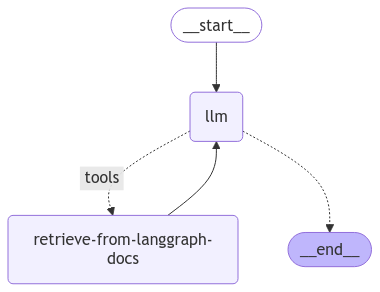

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from IPython.display import display, Image

builder = StateGraph(MessagesState)

builder.add_node("llm", ask_llm_langgraph_docs)
builder.add_node("retrieve-from-langgraph-docs", retrieve)

builder.add_edge(START, "llm")
builder.add_conditional_edges("llm",
                              tools_condition, 
                              {# Translate the condition outputs to nodes in our graph
                                "tools": "retrieve-from-langgraph-docs",
                                END: END,
                              },)

builder.add_edge("retrieve-from-langgraph-docs", "llm")

graph = builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Error with displaying the graph.")

In [19]:
input_message = {
    "messages": [
        ("user", "How to build a simple chatbot in langgraph?"),
    ],
}

graph.invoke(input_message)

---CALL AGENT---
PRINTING MESSAGES:
[HumanMessage(content='How to build a simple chatbot in langgraph?', additional_kwargs={}, response_metadata={}, id='2a784617-d129-4324-b8f4-3c66875b944b')]
---CALL AGENT---
PRINTING MESSAGES:
[HumanMessage(content='How to build a simple chatbot in langgraph?', additional_kwargs={}, response_metadata={}, id='2a784617-d129-4324-b8f4-3c66875b944b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sztvB8Dxdgpc6jMkBn1TCMiv', 'function': {'arguments': '{"query":"simple chatbot"}', 'name': 'retriever_langgraph_docs'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 69, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'fin

{'messages': [HumanMessage(content='How to build a simple chatbot in langgraph?', additional_kwargs={}, response_metadata={}, id='2a784617-d129-4324-b8f4-3c66875b944b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sztvB8Dxdgpc6jMkBn1TCMiv', 'function': {'arguments': '{"query":"simple chatbot"}', 'name': 'retriever_langgraph_docs'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 69, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9ba0fa79-d90a-4544-8f1c-dc5918769c36-0', tool_calls=[{'name': 'retriever_langgraph_docs', 'args': {'query': 'simple chatbot'}, 'id': 'call_sztvB8Dxdgpc6jMkBn1TC